In [1]:
#!git clone https://github.com/salesforce/BLIP
%cd BLIP

from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

C:\Users\Sammy\Projects\mm-reasoning\BLIP


C:\Users\Sammy\miniconda3\envs\VirtualEnv01\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Sammy\miniconda3\envs\VirtualEnv01\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Sammy\miniconda3\envs\VirtualEnv01\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


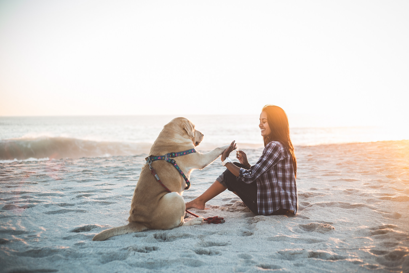

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a woman and her dog on the beach


In [2]:
from models.blip import blip_decoder

input_size = 384
image = load_demo_image(image_size=input_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
model = blip_decoder(pretrained=model_url, image_size=input_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])

In [17]:
import cv2
import numpy as np

def loadImage(image_path):
    raw_image = Image.open(image_path).convert('RGB')
    return raw_image    

def transformImage(img, input_size, device):   
    displayImage(img)
    transform = transforms.Compose([
        transforms.Resize((input_size,input_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
    image = transform(img).unsqueeze(0).to(device)   
    return image

def boundImage(img, bb):
    image = np.array(img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(bb)):
        color = [0,0,0]
        color[i-2] = 255 # different color for each bounding box (3 max)
        left, top = bb[i]['left'], bb[i]['top']
        width, height= bb[i]['width'], bb[i]['height']
    bounded = cv2.rectangle(image,(left,top),(left+width,top+height),color,2) # add rectangle to image
    bounded = cv2.cvtColor(bounded, cv2.COLOR_BGR2RGB)
    bounded = Image.fromarray(bounded)
    return bounded

def cropImage(img, bb):
    if len(bb) != 1:
        print("WARNING: Function cropImage has not yet been designed to fit multiple bounding boxes per image!")
        raise Exception("Bounding boxes should be a list of length one.")
    left, top = bb[0]['left'], bb[0]['top']
    width, height= bb[0]['width'], bb[0]['height']
    image = img.crop((left, top, left+width, top+height))
    return image

def displayImage(img):
    w,h = img.size
    display(img.resize((200*w//h,200)))

def captionImage(image):
    with torch.no_grad():
        # beam search
        caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
        # nucleus sampling
        #caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
        return(caption[0])

Example of validation set, val[0] =
{'inputs': {'image': {'url': 'https://cs.stanford.edu/people/rak248/VG_100K_2/2378438.jpg', 'width': 500, 'height': 375}, 'bboxes': [{'height': 168, 'width': 89, 'left': 329, 'top': 119}], 'clue': 'fruit cut in half', 'confidence': 2.0, 'obs_idx': 1}, 'targets': {'inference': 'people going to eat it'}, 'instance_id': 'c344c9b7dbee3d5d5dfcfc66c245b737', 'split_idx': 0}

Loaded 3 clues, inferences, and images.
Full print of all samples and correct labels:


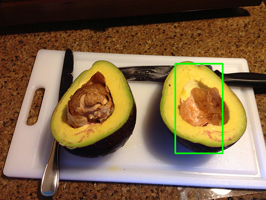

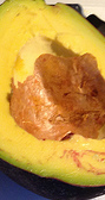

BLIP caption: the inside of an avoca
Sherlock clue: fruit cut in half 
-> people going to eat it


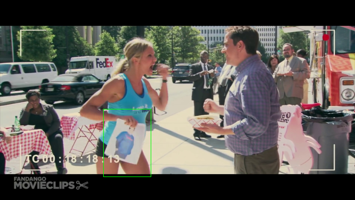

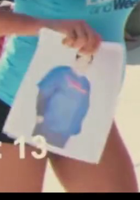

BLIP caption: a woman in a blue shirt
Sherlock clue: person on paper 
-> they are looking for a missing person.


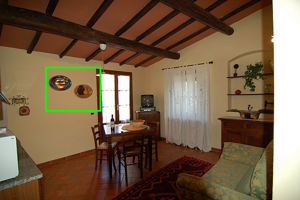

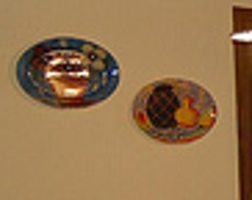

BLIP caption: a cat on a wall
Sherlock clue: two pieces of wall art 
-> The person who decorated this room likes old country art.


In [18]:
import os
import urllib.request
import zipfile
import json

size_cutoff = 3 # number of samples to include during computation
data_directory = 'sherlock_demo_directory'
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

# download the validation clues/inferences/images
data_url = 'https://storage.googleapis.com/ai2-mosaic-public/projects/sherlock/data/sherlock_val_with_split_idxs_v1_1.json.zip'
local_data_path = data_directory + '/sherlock_val_with_split_idxs_v1_1.json.zip'
if not os.path.exists(local_data_path):
    urllib.request.urlretrieve(data_url, local_data_path)

archive = zipfile.ZipFile(local_data_path, 'r')
with archive.open('sherlock_val_with_split_idxs_v1_1.json',mode='r') as f:
    val = json.load(f)
''' # sherlock demo code is commented
clues, inferences = [], []
all_clues = list(set([v['inputs']['clue'] for v in val]))
all_inferences = list(set([v['targets']['inference'] for v in val]))
np.random.shuffle(all_clues)
np.random.shuffle(all_inferences)
'''
print('Example of validation set, val[0] =\n{}\n'.format(val[0]))

all_clues = list([v['inputs']['clue'] for v in val])
all_inferences = list([v['targets']['inference'] for v in val])
all_images = list([v['inputs']['image']['url'] for v in val])
all_ids = list([v['instance_id'] for v in val])
all_bboxes = list([v['inputs']['bboxes'] for v in val])

if size_cutoff:
    all_clues = all_clues[:size_cutoff]
    all_inferences = all_inferences[:size_cutoff]
    all_images = all_images[:size_cutoff]
    all_ids = all_ids[:size_cutoff]
    all_bboxes = all_bboxes[:size_cutoff]
print('Loaded {} clues, inferences, and images.'.format(len(all_clues)))

def id2path(id):
    return data_directory + '/' + str(id) + '.jpg'

for i in range(len(all_ids)):
    image_path = id2path(all_ids[i])
    if not os.path.exists(image_path):
        urllib.request.urlretrieve(all_images[i], image_path)

if True:
    print('Full print of all samples and correct labels:')
    for i in range(len(all_ids)):
        image_path = id2path(all_ids[i])
        image = loadImage(image_path)
        bounded = boundImage(image, all_bboxes[i])
        displayImage(bounded)
        cropped = cropImage(image, all_bboxes[i])
        x = transformImage(cropped, input_size, device)
        caption = captionImage(x)
        print('BLIP caption:', caption)
        print('Sherlock clue:', all_clues[i], '\n->', all_inferences[i])